In [1]:
import duckdb
from pipelines.tasks._common import DUCKDB_FILE

con = duckdb.connect(database=DUCKDB_FILE, read_only=True)

In [2]:
from pandasql import sqldf
import pandas as pd
import geopandas as gpd
import folium
import os
from pyproj import Proj, transform
import numpy as np


In [3]:
communes = con.table("edc_communes").df()
res = con.table("edc_resultats").df()
prelev = con.table("edc_prelevements").df()

In [4]:
# quelles ARS et depuis quand elles analysent les PFAS ?

In [5]:
prelev.head()

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim
0,001,001000003,01007,AMBRONAY,None,None,None,00100139034,2024-01-23,11h27,Eau d'alimentation conforme aux limites de qua...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,N,C
1,001,001000003,01007,AMBRONAY,None,None,None,00100139393,2024-02-13,12h49,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
2,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100139969,2024-03-13,10h46,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
3,001,001000003,01007,AMBRONAY,None,None,None,00100140209,2024-04-05,07h27,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C
4,001,001000003,01007,AMBRONAY,None,None,None,00100140543,2024-05-13,12h43,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C


In [6]:
# on clean le dataframe prelev

# on converti toutes les codes postaux en chaines de caractère
# prelev["inseecommuneprinc"] = prelev["inseecommuneprinc"].astype(str)

In [7]:
# Liste des 20 PFAS actuellement recherchés par les ARS
pfas = np.array(
    [
        5977,
        5978,
        5979,
        5980,
        5347,
        6508,
        6507,
        6509,
        6510,
        6549,
        6025,
        8738,
        6830,
        6542,
        6560,
        8739,
        6550,
        8740,
        8741,
        8742,
    ]
)

res["libminparametre"][np.isin(res.cdparametre, pfas)].unique()

array(['Acide perfluorobutanoïque', 'Perfluorobutane sulfonate',
       'Acide perfluoro-decanoïque',
       'Acide perfluorododécanoique (PFDoDA)',
       'Acide perfluorododécane sulfonique (PFDoDS)',
       'Acide perfluorodecane sulfonique ', 'Acide perfluoroheptanoïque',
       'Acide perfluoroheptane sulfonique (PFHpS)',
       'Acide perfluorohexanoïque', 'Perfluorohexane sulfonate',
       'Acide perfluoro-nonanoïque',
       'Acide perfluorononane sulfonique (PFNS)',
       'Acide perfluoro-octanoïque', 'Acide perfluoropentanoïque',
       'Acide perfluoropentane sulfonique (PFPS)',
       'Acide perfluoro tridecanoique (PFTrDA)',
       'Acide perfluoro tridecane sulfonique (PFTrDS)',
       'Acide perfluoro undecanoïque (PFUnA)',
       'Acide perfluoro undecane sulfonique (PFUnDS)'], dtype=object)

In [8]:
pfas[np.invert(np.isin(pfas, res.cdparametre))]

array([6560])

Les données ne contiennent pas le PFAS 6560/"Acide perfluorooctane sulfonique", voir avec Pauline?

In [9]:
# Parmi tous les résultats on ne garde que les résultats qui mentionnent les PFAS
res_pfas = res[np.isin(res.cdparametre, pfas)]
res_pfas.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl
35185,001,00100140027,PFBA,5980.0,ACIDE PERFLUOROBUTANOÏQUE,Acide perfluorobutanoïque,None,N,L,"0,0016",µg/L,133,None,None,0.0016,375-22-4,00100148857
35186,001,00100140027,PFBS,6025.0,PERFLUOROBUTANE SULFONATE,Perfluorobutane sulfonate,None,N,L,"<0,001",µg/L,133,None,None,0.0000,59933-66-3,00100148857
35187,001,00100140027,PFDA,6509.0,ACIDE PERFLUORO-DECANOÏQUE,Acide perfluoro-decanoïque,None,N,L,"<0,001",µg/L,133,None,None,0.0000,335-76-2,00100148857
35188,001,00100140027,PFDODA,6507.0,ACIDE PERFLUORODODÉCANOIQUE,Acide perfluorododécanoique (PFDoDA),None,N,L,"<0,001",µg/L,133,None,None,0.0000,307-55-1,00100148857
35189,001,00100140027,PFDODS,8741.0,ACIDE PERFLUORODODÉCANE SULFONIQUE,Acide perfluorododécane sulfonique (PFDoDS),None,N,L,"<0,001",µg/L,133,None,None,0.0000,79780-39-5,00100148857


La liste des départements qui ont mesuré les PFAS en 2024 est la suivante:

In [10]:
dpt_pfas = res_pfas["cddept"].astype(int).unique()
dpt_pfas

array([ 1,  3,  4,  5,  6,  7,  8, 11, 13, 18, 21, 25, 26, 28, 30, 34, 36,
       37, 38, 39, 41, 42, 45, 57, 58, 62, 63, 68, 69, 70, 71, 73, 74, 78,
       80, 83, 84, 86, 89, 90, 92])

In [11]:
res_pfas["cddept"] = res_pfas["cddept"].astype(int)

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\56647353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_pfas["cddept"] = res_pfas["cddept"].astype(int)


Seuls 41 départements sur 111 ont déclaré des données sur les PFAS (sauf le 6560/"Acide perfluorooctane sulfonique") en 2024
L’arrêté basé sur la directive européenne (transposition en droit français en décembre 2022) fixe la limite de qualité à 0,10 µg/L pour la somme de ces 20 molécules dans les eaux de consommation humaines.

In [12]:
# Test bdd utilisées par les data eng

In [13]:
geo = pd.read_csv(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\20230823-communes-departement-region (1).csv"
)

In [14]:
geo.head()

,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84.0,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84.0,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84.0,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84.0,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84.0,Auvergne-Rhône-Alpes


In [15]:
# données des tracés geo: https://github.com/gregoiredavid/france-geojson/tree/master

In [80]:
region = gpd.read_file(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\regions-version-simplifiee.geojson"
)

In [81]:
region.head()

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.07822 49.38849..."
4,32,Hauts-de-France,"POLYGON ((4.04797 49.40564, 4.03991 49.3974, 4..."


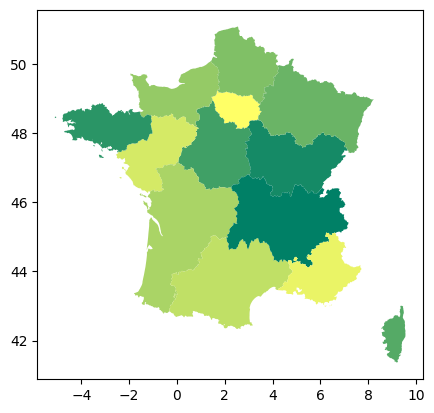

In [82]:
import matplotlib.pyplot as plt

region.plot(column="nom", cmap="summer")
plt.show()

In [19]:
geo_clean = geo.dropna(subset=["code_region"])
geo_clean["code_region"] = geo_clean["code_region"].astype(int)
geo_clean.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1187646247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clean["code_region"] = geo_clean["code_region"].astype(int)


,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84,Auvergne-Rhône-Alpes


In [20]:
# on sélectionne le code_region,nom_region des régions qui correspondent aux départements où on été étudiés les pfas en 2024
regions_pfas = sqldf("""SELECT code_region,nom_region
FROM geo_clean
WHERE code_departement IN
       (SELECT cddept FROM res_pfas)""")

Liste des régions ayant recherchés des PFAS en 2024 (par code de région):

In [21]:
regions_pfas["code_region"].unique()

array([84, 93, 44, 76, 24, 27, 32, 11, 75])

Liste des régions ayant recherchés des PFAS en 2024 (par nom):

In [22]:
regions_pfas["nom_region"].unique()

array(['Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur", 'Grand Est',
       'Occitanie', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté',
       'Hauts-de-France', 'Île-de-France', 'Nouvelle-Aquitaine'],
      dtype=object)

In [23]:
res_pfas.columns

Index(['cddept', 'referenceprel', 'cdparametresiseeaux', 'cdparametre',
       'libmajparametre', 'libminparametre', 'libwebparametre', 'qualitparam',
       'insituana', 'rqana', 'cdunitereferencesiseeaux', 'cdunitereference',
       'limitequal', 'refqual', 'valtraduite', 'casparam', 'referenceanl'],
      dtype='object')

In [24]:
geo_clean.columns

Index(['code_commune_INSEE', 'nom_commune_postal', 'code_postal',
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude',
       'code_commune', 'article', 'nom_commune', 'nom_commune_complet',
       'code_departement', 'nom_departement', 'code_region', 'nom_region'],
      dtype='object')

In [31]:
# cddept,res_pfas.cdparametre, res_pfas.rqana,res_pfas.referenceprel,res_pfas.libminparametre,res_pfas.refqual,res_pfas.valtraduite, res_pfas.casparam


res_pfas_regions = sqldf("""SELECT res_pfas.cddept,res_pfas.cdparametre, res_pfas.rqana,res_pfas.referenceprel,res_pfas.libminparametre,res_pfas.refqual,res_pfas.valtraduite, res_pfas.casparam,res_pfas.limitequal,geo_clean.code_departement,geo_clean.code_region,geo_clean.nom_region
FROM res_pfas
JOIN geo_clean
ON res_pfas.cddept = geo_clean.code_departement""")

In [32]:
res_pfas_regions.head()

,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,code_region,nom_region
0,1,5347.0,"<0,001",00100140027,Acide perfluoro-octanoïque,None,0.0000,335-67-1,None,1,84,Auvergne-Rhône-Alpes
1,1,5977.0,"0,0016",00100140027,Acide perfluoroheptanoïque,None,0.0016,375-85-9,None,1,84,Auvergne-Rhône-Alpes
2,1,5978.0,"0,0054",00100140027,Acide perfluorohexanoïque,None,0.0054,307-24-4,None,1,84,Auvergne-Rhône-Alpes
3,1,5979.0,"0,0019",00100140027,Acide perfluoropentanoïque,None,0.0019,2706-90-3,None,1,84,Auvergne-Rhône-Alpes
4,1,5980.0,"0,0016",00100140027,Acide perfluorobutanoïque,None,0.0016,375-22-4,None,1,84,Auvergne-Rhône-Alpes


In [ ]:
res_pfas_regions["cdparametre"] = res_pfas_regions["cdparametre"].astype(int)
res_pfas_regions.head()

NameError: name 'res' is not defined

In [34]:
res_pfas_regions.columns

Index(['cddept', 'cdparametre', 'rqana', 'referenceprel', 'libminparametre',
       'refqual', 'valtraduite', 'casparam', 'limitequal', 'code_departement',
       'code_region', 'nom_region'],
      dtype='object')

In [ ]:
res_pfas_groupregions = res_pfas_regions.groupby("code_region").agg(list)
res_pfas_groupregions.head()

# geo_clean_data = geo_clean.assign(qtt_pfas=pauvsect3["men_pauv"].div(pauvsect3["men"]))

,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,nom_region
code_region,,,,,,,,,,,
11,"[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,001, <0,001, <0,002, <0,001, <0,001, <0,00...","[07800242644, 07800242644, 07800242644, 078002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[Île-de-France, Île-de-France, Île-de-France, ..."
24,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,015, 0,004, 0,010, 0,011, 0,005, 0,004, <0,...","[01800094345, 01800094345, 01800094345, 018000...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.015, 0.004, 0.01, 0.011, 0.005, 0.004, 0.0,...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[Centre-Val de Loire, Centre-Val de Loire, Cen..."
27,"[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,0005, <0,0005, <0,001, <0,001, 0,0041, <0,...","[02100167243, 02100167243, 02100167243, 021001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0041, 0.0, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[Bourgogne-Franche-Comté, Bourgogne-Franche-Co..."
32,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,006, 0,001, <0,002, 0,002, 0,002, <0,001, <...","[06200285752, 06200285752, 06200285752, 062002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.006, 0.001, 0.0, 0.002, 0.002, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[Hauts-de-France, Hauts-de-France, Hauts-de-Fr..."
44,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,0015, <0,001, 0,0038, 0,0033, 0,0016, 0,004...","[00800103772, 00800103772, 00800103772, 008001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0015, 0.0, 0.0038, 0.0033, 0.0016, 0.0044, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[Grand Est, Grand Est, Grand Est, Grand Est, G..."


In [40]:
res_pfas_groupregions2 = res_pfas_groupregions.reset_index()

In [45]:
res_pfas_groupregions2.head()

,code_region,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,code_departement,nom_region
0,11,"[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,001, <0,001, <0,002, <0,001, <0,001, <0,00...","[07800242644, 07800242644, 07800242644, 078002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 7...","[Île-de-France, Île-de-France, Île-de-France, ..."
1,24,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,015, 0,004, 0,010, 0,011, 0,005, 0,004, <0,...","[01800094345, 01800094345, 01800094345, 018000...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.015, 0.004, 0.01, 0.011, 0.005, 0.004, 0.0,...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[Centre-Val de Loire, Centre-Val de Loire, Cen..."
2,27,"[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[<0,0005, <0,0005, <0,001, <0,001, 0,0041, <0,...","[02100167243, 02100167243, 02100167243, 021001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0041, 0.0, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2...","[Bourgogne-Franche-Comté, Bourgogne-Franche-Co..."
3,32,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,006, 0,001, <0,002, 0,002, 0,002, <0,001, <...","[06200285752, 06200285752, 06200285752, 062002...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.006, 0.001, 0.0, 0.002, 0.002, 0.0, 0.0, 0....","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[Hauts-de-France, Hauts-de-France, Hauts-de-Fr..."
4,44,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[5347, 5977, 5978, 5979, 5980, 6025, 6507, 650...","[0,0015, <0,001, 0,0038, 0,0033, 0,0016, 0,004...","[00800103772, 00800103772, 00800103772, 008001...","[Acide perfluoro-octanoïque, Acide perfluorohe...","[None, None, None, None, None, None, None, Non...","[0.0015, 0.0, 0.0038, 0.0033, 0.0016, 0.0044, ...","[335-67-1, 375-85-9, 307-24-4, 2706-90-3, 375-...","[None, None, None, None, None, None, None, Non...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[Grand Est, Grand Est, Grand Est, Grand Est, G..."


In [55]:
df = res_pfas_groupregions2[["cdparametre"]]
df["cdparametre"] = df["cdparametre"].apply(lambda x: np.array(x))
df["cdparametre"] = df["cdparametre"].apply(lambda x: np.unique(x))
df["cdparametre"] = df["cdparametre"].apply(lambda x: np.unique(x).size)
df.head()
# res_pfas_groupregions3 = res_pfas_groupregions2.assign(cb_pfas=)

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\3214782953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cdparametre'] = df['cdparametre'].apply(lambda x: np.array(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\3214782953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cdparametre'] = df['cdparametre'].apply(lambda x: np.unique(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\3214782953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,cdparametre
0,19
1,19
2,19
3,19
4,19


In [56]:
res_pfas_groupregions3 = res_pfas_groupregions2.assign(cb_pfas=df)

In [60]:
res_pfas_groupregions3[["nom_region", "cb_pfas"]]

,nom_region,cb_pfas
0,"[Île-de-France, Île-de-France, Île-de-France, ...",19
1,"[Centre-Val de Loire, Centre-Val de Loire, Cen...",19
2,"[Bourgogne-Franche-Comté, Bourgogne-Franche-Co...",19
3,"[Hauts-de-France, Hauts-de-France, Hauts-de-Fr...",19
4,"[Grand Est, Grand Est, Grand Est, Grand Est, G...",19
5,"[Nouvelle-Aquitaine, Nouvelle-Aquitaine, Nouve...",19
6,"[Occitanie, Occitanie, Occitanie, Occitanie, O...",19
7,"[Auvergne-Rhône-Alpes, Auvergne-Rhône-Alpes, A...",19
8,"[Provence-Alpes-Côte d'Azur, Provence-Alpes-Cô...",19


Parmis les 9 régions ayant recherchés des PFAS en 2024, toutes ont recherché 19 PFAS parmi la liste des 20 PFAS "reconnus". Le PFAS manquant est toujours le 6560/"Acide perfluorooctane sulfonique", entièrement absent de la base de données.

In [62]:
res_pfas_groupregions2.columns

Index(['code_region', 'cddept', 'cdparametre', 'rqana', 'referenceprel',
       'libminparametre', 'refqual', 'valtraduite', 'casparam', 'limitequal',
       'code_departement', 'nom_region'],
      dtype='object')

In [65]:
# on étudie maintenant le nombre de prélevements différents effectués sur les PFAS par région en 2024
df2 = res_pfas_groupregions2[["referenceprel"]]
df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.array(x))
df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.unique(x))
df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.unique(x).size)
df2.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1656525643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.array(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1656525643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["referenceprel"] = df2["referenceprel"].apply(lambda x: np.unique(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1656525643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

,referenceprel
0,3
1,160
2,53
3,7
4,90


In [69]:
res_pfas_groupregions4 = res_pfas_groupregions3.assign(cb_prel=df2)

In [ ]:
# colonne clean pour le nom des régions
df3 = res_pfas_groupregions2[["nom_region"]]
df3["nom_region"] = df3["nom_region"].apply(lambda x: np.array(x)[0])
df3.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\4071933369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["nom_region"] = df3["nom_region"].apply(lambda x: np.array(x)[0])


,nom_region
0,Île-de-France
1,Centre-Val de Loire
2,Bourgogne-Franche-Comté
3,Hauts-de-France
4,Grand Est


In [71]:
res_pfas_groupregions5 = res_pfas_groupregions4.assign(nom_region_clean=df3)

Un tableau qui montre combien de prélèvements différents ont été effectués pour rechercher les PFAS par région en 2024:

In [73]:
res_pfas_groupregions5[["nom_region_clean", "cb_prel"]]

,nom_region_clean,cb_prel
0,Île-de-France,3
1,Centre-Val de Loire,160
2,Bourgogne-Franche-Comté,53
3,Hauts-de-France,7
4,Grand Est,90
5,Nouvelle-Aquitaine,1
6,Occitanie,75
7,Auvergne-Rhône-Alpes,493
8,Provence-Alpes-Côte d'Azur,399


In [74]:
# chercher les dates des prélèvements et les représenter graphiquement

Représentation cartographique des ARS ayant recherché au moins un PFAS en 2024:

In [ ]:
m = folium.Map(location=[48.86, 2.33], zoom_start=5, tiles="cartodb positron")

cp = folium.Choropleth(
    geo_data=region,
    name="choropleth",
    data=res_pfas_groupregions5,
    columns=["code_region", "cb_prel"],
    key_on="feature.properties.code",
    fill_color="PuBuGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nombre de prélèvements distincts sur les PFAS",
).add_to(m)

folium.LayerControl().add_to(m)

# folium.GeoJsonTooltip(["nom_region_clean", "cb_prel"]).add_to(cp.geojson)


m

Etude par département

In [99]:
departement = gpd.read_file(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\departements-version-simplifiee.geojson"
)

In [100]:
departement.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.3974, 4..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


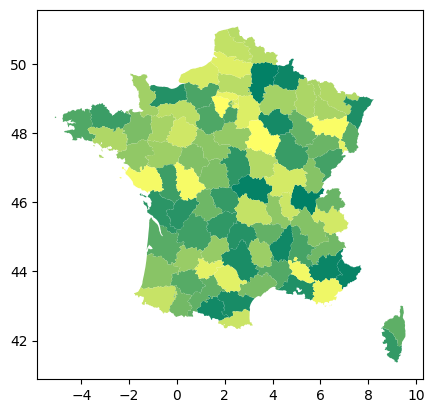

In [101]:
departement.plot(column="nom", cmap="summer")
plt.show()

In [102]:
res_pfas.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl
35185,1,00100140027,PFBA,5980.0,ACIDE PERFLUOROBUTANOÏQUE,Acide perfluorobutanoïque,None,N,L,"0,0016",µg/L,133,None,None,0.0016,375-22-4,00100148857
35186,1,00100140027,PFBS,6025.0,PERFLUOROBUTANE SULFONATE,Perfluorobutane sulfonate,None,N,L,"<0,001",µg/L,133,None,None,0.0000,59933-66-3,00100148857
35187,1,00100140027,PFDA,6509.0,ACIDE PERFLUORO-DECANOÏQUE,Acide perfluoro-decanoïque,None,N,L,"<0,001",µg/L,133,None,None,0.0000,335-76-2,00100148857
35188,1,00100140027,PFDODA,6507.0,ACIDE PERFLUORODODÉCANOIQUE,Acide perfluorododécanoique (PFDoDA),None,N,L,"<0,001",µg/L,133,None,None,0.0000,307-55-1,00100148857
35189,1,00100140027,PFDODS,8741.0,ACIDE PERFLUORODODÉCANE SULFONIQUE,Acide perfluorododécane sulfonique (PFDoDS),None,N,L,"<0,001",µg/L,133,None,None,0.0000,79780-39-5,00100148857


In [ ]:
insee = pd.read_csv(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\correspondance-code-insee-code-postal.csv",
    sep=";",
)

In [107]:
insee.head()

,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,66033,66300,CAMELAS,['PYRENEES-ORIENTALES'],['LANGUEDOC-ROUSSILLON'],['Commune simple'],256.0,1299.0,0.4,"42.639460715710925, 2.6889148905394613","{""coordinates"": [[[2.673016106975883, 42.61202...",35535,33,17,2,66,91
1,64254,64370,HAGETAUBIN,['PYRENEES-ATLANTIQUES'],['AQUITAINE'],['Commune simple'],106.0,1874.0,0.5,"43.510561909594024, -0.612895161323306","{""coordinates"": [[[-0.5869934199585, 43.487993...",905,254,3,3,64,72
2,47260,47270,SAINT-MAURIN,['LOT-ET-GARONNE'],['AQUITAINE'],['Commune simple'],143.0,2187.0,0.5,"44.21584680376108, 0.8936370457330151","{""coordinates"": [[[0.9031113551375021, 44.1900...",750,260,4,1,47,72
3,80118,80150,BOUFFLERS,['SOMME'],['PICARDIE'],['Commune simple'],50.0,557.0,0.1,"50.25894479050434, 2.021288658965274","{""coordinates"": [[[2.041095653892836, 50.24688...",26556,118,19,1,80,22
4,46147,46220,LAGARDELLE,['LOT'],['MIDI-PYRENEES'],['Commune simple'],110.0,317.0,0.1,"44.48709070580215, 1.170693334968643","{""coordinates"": [[[1.180099496531688, 44.47195...",34133,147,23,1,46,73


In [108]:
insee.columns

Index(['Code INSEE', 'Code Postal', 'Commune', 'Département', 'Région',
       'Statut', 'Altitude Moyenne', 'Superficie', 'Population',
       'geo_point_2d', 'geo_shape', 'ID Geofla', 'Code Commune', 'Code Canton',
       'Code Arrondissement', 'Code Département', 'Code Région'],
      dtype='object')

In [120]:
# On join res_pfas et prelev pour avoir le code insee correspondant à chaque analyse dans résultat
res_pfas_joinprelevcodeinsee = sqldf("""SELECT res_pfas.cddept,res_pfas.cdparametre, res_pfas.rqana,res_pfas.referenceprel,res_pfas.libminparametre,res_pfas.refqual,res_pfas.valtraduite, res_pfas.casparam,res_pfas.limitequal,prelev.inseecommuneprinc
FROM res_pfas
JOIN prelev
ON res_pfas.referenceprel = prelev.referenceprel""")

In [121]:
res_pfas_joinprelevcodeinsee.head()

,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,inseecommuneprinc
0,1,5980.0,"0,0016",00100140027,Acide perfluorobutanoïque,None,0.0016,375-22-4,None,01027
1,1,6025.0,"<0,001",00100140027,Perfluorobutane sulfonate,None,0.0000,59933-66-3,None,01027
2,1,6509.0,"<0,001",00100140027,Acide perfluoro-decanoïque,None,0.0000,335-76-2,None,01027
3,1,6507.0,"<0,001",00100140027,Acide perfluorododécanoique (PFDoDA),None,0.0000,307-55-1,None,01027
4,1,8741.0,"<0,001",00100140027,Acide perfluorododécane sulfonique (PFDoDS),None,0.0000,79780-39-5,None,01027


In [123]:
res_pfas_insee = sqldf("""SELECT res_pfas_joinprelevcodeinsee.inseecommuneprinc,res_pfas_joinprelevcodeinsee.cddept,res_pfas_joinprelevcodeinsee.cdparametre, res_pfas_joinprelevcodeinsee.rqana,res_pfas_joinprelevcodeinsee.referenceprel,res_pfas_joinprelevcodeinsee.libminparametre,res_pfas_joinprelevcodeinsee.refqual,res_pfas_joinprelevcodeinsee.valtraduite, res_pfas_joinprelevcodeinsee.casparam,res_pfas_joinprelevcodeinsee.limitequal,insee.[Code Postal], insee.[Commune],insee.[Code Département]
FROM res_pfas_joinprelevcodeinsee
JOIN insee
ON res_pfas_joinprelevcodeinsee.inseecommuneprinc = insee.[Code INSEE]""")

In [124]:
res_pfas_insee.head()

,inseecommuneprinc,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,Code Postal,Commune,Code Département
0,01027,1,5980.0,"0,0016",00100140027,Acide perfluorobutanoïque,None,0.0016,375-22-4,None,01360,BALAN,01
1,01027,1,6025.0,"<0,001",00100140027,Perfluorobutane sulfonate,None,0.0000,59933-66-3,None,01360,BALAN,01
2,01027,1,6509.0,"<0,001",00100140027,Acide perfluoro-decanoïque,None,0.0000,335-76-2,None,01360,BALAN,01
3,01027,1,6507.0,"<0,001",00100140027,Acide perfluorododécanoique (PFDoDA),None,0.0000,307-55-1,None,01360,BALAN,01
4,01027,1,8741.0,"<0,001",00100140027,Acide perfluorododécane sulfonique (PFDoDS),None,0.0000,79780-39-5,None,01360,BALAN,01


On a donc désormais une table qui donne, pour chaque prélèvement sur les PFAS, le code postal et le code départemental correspondant

In [ ]:
# On créer une nouvelle table, dans laquelle on va aggréger les données par département sous forme de liste, i.e la colonne cdparametre (par exemple, mais pareil pour toutes) contiendra une liste des paramètres étudiés dans le département (avec doublons si plusieurs prélèvements en 2024)
# Ensuite on convertira les listes crées en array numpy pour pouvoir virer les doublons, le but étant de compter le nombre de prélèvements effectués sur les pfas par département
# Ils font un prélèvement et analysent ensuite chaque pfas depuis ce prélèvement, donc la referenceprel apparaît 19 fois dans la liste, on ne veut pas ça, c'est pour ça qu'on évacue les doublons
res_pfas_insee_gbdept0 = res_pfas_insee.groupby("Code Département").agg(list)
res_pfas_insee_gbdept = res_pfas_insee_gbdept0.reset_index()
res_pfas_insee_gbdept.head()

,Code Département,inseecommuneprinc,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,Code Postal,Commune
0,01,"[01027, 01027, 01027, 01027, 01027, 01027, 010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,0016, <0,001, <0,001, <0,001, <0,001, <0,00...","[00100140027, 00100140027, 00100140027, 001001...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.0016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016, 0.0,...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[01360, 01360, 01360, 01360, 01360, 01360, 013...","[BALAN, BALAN, BALAN, BALAN, BALAN, BALAN, BAL..."
1,03,"[03236, 03236, 03236, 03236, 03236, 03236, 032...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,002, <0,001, <0,001, <0,001, <0,001, <0,001...","[00300098549, 00300098549, 00300098549, 003000...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047, 0.0, ...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[03260, 03260, 03260, 03260, 03260, 03260, 032...","[SAINT-GERMAIN-DES-FOSSES, SAINT-GERMAIN-DES-F..."
2,04,"[04112, 04112, 04112, 04112, 04112, 04112, 041...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[5980.0, 5980.0, 6025.0, 6025.0, 6509.0, 6509....","[<0,001, <0,001, <0,001, <0,001, <0,001, <0,00...","[00400141510, 00400141510, 00400141510, 004001...","[Acide perfluorobutanoïque, Acide perfluorobut...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[375-22-4, 375-22-4, 59933-66-3, 59933-66-3, 3...","[None, None, None, None, None, None, None, Non...","[04100, 04100, 04100, 04100, 04100, 04100, 041...","[MANOSQUE, MANOSQUE, MANOSQUE, MANOSQUE, MANOS..."
3,05,"[05001, 05001, 05001, 05001, 05001, 05001, 050...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[<0,001, <0,001, <0,001, <0,001, <0,001, <0,00...","[00500133697, 00500133697, 00500133697, 005001...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[05460, 05460, 05460, 05460, 05460, 05460, 054...","[ABRIES, ABRIES, ABRIES, ABRIES, ABRIES, ABRIE..."
4,06,"[06084, 06084, 06084, 06084, 06084, 06084, 060...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,003, 0,002, <0,001, <0,001, <0,001, <0,001,...","[00600255895, 00600255895, 00600255895, 006002...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.003, 0.002, 0.0, 0.0, 0.0, 0.0, 0.003, 0.0,...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[06370, 06370, 06370, 06370, 06370, 06370, 063...","[MOUANS-SARTOUX, MOUANS-SARTOUX, MOUANS-SARTOU..."


In [127]:
# On ne prend que la colonne referenceprel, on converti les listes en array, on vire les doublons et on compte
dfdept = res_pfas_insee_gbdept[["referenceprel"]]
dfdept["referenceprel"] = dfdept["referenceprel"].apply(lambda x: np.array(x))
dfdept["referenceprel"] = dfdept["referenceprel"].apply(lambda x: np.unique(x))
dfdept["referenceprel"] = dfdept["referenceprel"].apply(lambda x: np.unique(x).size)
dfdept.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\2064135913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdept["referenceprel"] = dfdept["referenceprel"].apply(lambda x: np.array(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\2064135913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdept["referenceprel"] = dfdept["referenceprel"].apply(lambda x: np.unique(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\2064135913.py:5: SettingWithCopyWarning: 
A value is trying to

,referenceprel
0,10
1,31
2,122
3,83
4,84


In [128]:
res_pfas_insee_gbdept2 = res_pfas_insee_gbdept.assign(cb_prel=dfdept)

In [131]:
res_pfas_insee_gbdept2[["Code Département", "cb_prel"]]

,Code Département,cb_prel
0,01,10
1,03,31
2,04,122
3,05,83
4,06,84
5,07,90
6,08,25
7,11,63
8,13,15
9,18,11


Représentation cartographique du nombre de prélèvements concernant les PFAS en 2024 à l'échelle des départements français

In [133]:
m = folium.Map(location=[48.86, 2.33], zoom_start=5, tiles="cartodb positron")

cp = folium.Choropleth(
    geo_data=departement,
    name="choropleth",
    data=res_pfas_insee_gbdept2,
    columns=["Code Département", "cb_prel"],
    key_on="feature.properties.code",
    fill_color="PuBuGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nombre de prélèvements distincts sur les PFAS",
).add_to(m)

folium.LayerControl().add_to(m)

# folium.GeoJsonTooltip(["nom_region_clean", "cb_prel"]).add_to(cp.geojson)


m

Etude par commune

In [134]:
res_pfas_insee.head()

,inseecommuneprinc,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,Code Postal,Commune,Code Département
0,01027,1,5980.0,"0,0016",00100140027,Acide perfluorobutanoïque,None,0.0016,375-22-4,None,01360,BALAN,01
1,01027,1,6025.0,"<0,001",00100140027,Perfluorobutane sulfonate,None,0.0000,59933-66-3,None,01360,BALAN,01
2,01027,1,6509.0,"<0,001",00100140027,Acide perfluoro-decanoïque,None,0.0000,335-76-2,None,01360,BALAN,01
3,01027,1,6507.0,"<0,001",00100140027,Acide perfluorododécanoique (PFDoDA),None,0.0000,307-55-1,None,01360,BALAN,01
4,01027,1,8741.0,"<0,001",00100140027,Acide perfluorododécane sulfonique (PFDoDS),None,0.0000,79780-39-5,None,01360,BALAN,01


In [135]:
commune_geo = gpd.read_file(
    r"C:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\database\communes-version-simplifiee.geojson"
)

In [136]:
commune_geo.head()

,code,nom,geometry
0,01073,Ceyzérieu,"POLYGON ((5.69816 45.86166, 5.70471 45.86125, ..."
1,01262,Montluel,"POLYGON ((5.06729 45.88115, 5.0737 45.87243, 5..."
2,01425,Tranclière,"POLYGON ((5.23549 46.10047, 5.23991 46.11296, ..."
3,02042,Azy-sur-Marne,"POLYGON ((3.34368 48.99501, 3.33626 48.99923, ..."
4,02140,Camelin,"POLYGON ((3.09633 49.5179, 3.12117 49.52097, 3..."


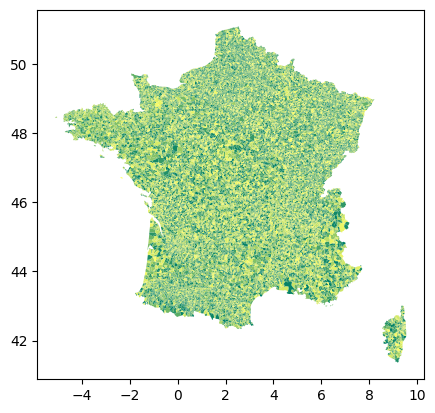

In [137]:
commune_geo.plot(column="nom", cmap="summer")
plt.show()

In [138]:
res_pfas_insee_gbcommune = res_pfas_insee.groupby("inseecommuneprinc").agg(list)
res_pfas_insee_gbcommune = res_pfas_insee_gbcommune.reset_index()
res_pfas_insee_gbcommune.head()

,inseecommuneprinc,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,Code Postal,Commune,Code Département
0,01027,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,0016, <0,001, <0,001, <0,001, <0,001, <0,00...","[00100140027, 00100140027, 00100140027, 001001...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.0016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016, 0.0,...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[01360, 01360, 01360, 01360, 01360, 01360, 013...","[BALAN, BALAN, BALAN, BALAN, BALAN, BALAN, BAL...","[01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 0..."
1,01283,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 5980.0, 5980.0, 6025.0, 6025.0, 6025....","[<0,005, <0,005, <0,005, <0,002, <0,002, <0,00...","[00100143331, 00100143331, 00100143331, 001001...","[Acide perfluorobutanoïque, Acide perfluorobut...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[375-22-4, 375-22-4, 375-22-4, 59933-66-3, 599...","[None, None, None, None, None, None, None, Non...","[01100, 01100, 01100, 01100, 01100, 01100, 011...","[OYONNAX, OYONNAX, OYONNAX, OYONNAX, OYONNAX, ...","[01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 0..."
2,01403,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,001, <0,001, <0,001, <0,001, <0,001, <0,001...","[00100143242, 00100143242, 00100143242, 001001...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[01470, 01470, 01470, 01470, 01470, 01470, 014...","[SERRIERES-DE-BRIORD, SERRIERES-DE-BRIORD, SER...","[01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 0..."
3,03232,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[<0,001, <0,001, <0,001, <0,001, <0,001, <0,00...","[00300098550, 00300098550, 00300098550, 003000...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[03260, 03260, 03260, 03260, 03260, 03260, 032...","[SAINT-FELIX, SAINT-FELIX, SAINT-FELIX, SAINT-...","[03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 0..."
4,03236,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,002, <0,001, <0,001, <0,001, <0,001, <0,001...","[00300098549, 00300098549, 00300098549, 003000...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047, 0.0, ...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[03260, 03260, 03260, 03260, 03260, 03260, 032...","[SAINT-GERMAIN-DES-FOSSES, SAINT-GERMAIN-DES-F...","[03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 0..."


In [139]:
dfcommune = res_pfas_insee_gbcommune[["referenceprel"]]
dfcommune["referenceprel"] = dfcommune["referenceprel"].apply(lambda x: np.array(x))
dfcommune["referenceprel"] = dfcommune["referenceprel"].apply(lambda x: np.unique(x))
dfcommune["referenceprel"] = dfcommune["referenceprel"].apply(
    lambda x: np.unique(x).size
)
dfcommune.head()

C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1512044639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcommune["referenceprel"] = dfcommune["referenceprel"].apply(lambda x: np.array(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1512044639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcommune["referenceprel"] = dfcommune["referenceprel"].apply(lambda x: np.unique(x))
C:\Users\emma.david\AppData\Local\Temp\ipykernel_22352\1512044639.py:4: SettingWithCopyWarning: 
A value 

,referenceprel
0,8
1,1
2,1
3,4
4,5


In [140]:
res_pfas_insee_gbcommune2 = res_pfas_insee_gbcommune.assign(cb_prel=dfcommune)

In [141]:
res_pfas_insee_gbcommune2[["inseecommuneprinc", "cb_prel"]]

,inseecommuneprinc,cb_prel
0,01027,8
1,01283,1
2,01403,1
3,03232,4
4,03236,5
...,...,...
534,86066,1
535,89268,1
536,89387,2
537,90006,1


In [153]:
res_prepsql = res_pfas_insee_gbcommune2[["inseecommuneprinc", "cb_prel"]]

In [154]:
res_prepsql.head()

,inseecommuneprinc,cb_prel
0,01027,8
1,01283,1
2,01403,1
3,03232,4
4,03236,5


In [ ]:
# on fait une liste de toutes les communes qui ne sont PAS dans res_pfas_insee_gbcommune2

nanns = np.invert(
    np.isin(commune_geo["code"], res_pfas_insee_gbcommune2["inseecommuneprinc"])
)
print(np.sum(nanns))

34689


In [152]:
res_pfas_insee_gbcommune2.head()

,inseecommuneprinc,cddept,cdparametre,rqana,referenceprel,libminparametre,refqual,valtraduite,casparam,limitequal,Code Postal,Commune,Code Département,cb_prel
0,01027,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,0016, <0,001, <0,001, <0,001, <0,001, <0,00...","[00100140027, 00100140027, 00100140027, 001001...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.0016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016, 0.0,...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[01360, 01360, 01360, 01360, 01360, 01360, 013...","[BALAN, BALAN, BALAN, BALAN, BALAN, BALAN, BAL...","[01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 0...",8
1,01283,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 5980.0, 5980.0, 6025.0, 6025.0, 6025....","[<0,005, <0,005, <0,005, <0,002, <0,002, <0,00...","[00100143331, 00100143331, 00100143331, 001001...","[Acide perfluorobutanoïque, Acide perfluorobut...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[375-22-4, 375-22-4, 375-22-4, 59933-66-3, 599...","[None, None, None, None, None, None, None, Non...","[01100, 01100, 01100, 01100, 01100, 01100, 011...","[OYONNAX, OYONNAX, OYONNAX, OYONNAX, OYONNAX, ...","[01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 0...",1
2,01403,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,001, <0,001, <0,001, <0,001, <0,001, <0,001...","[00100143242, 00100143242, 00100143242, 001001...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[01470, 01470, 01470, 01470, 01470, 01470, 014...","[SERRIERES-DE-BRIORD, SERRIERES-DE-BRIORD, SER...","[01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 01, 0...",1
3,03232,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[<0,001, <0,001, <0,001, <0,001, <0,001, <0,00...","[00300098550, 00300098550, 00300098550, 003000...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[03260, 03260, 03260, 03260, 03260, 03260, 032...","[SAINT-FELIX, SAINT-FELIX, SAINT-FELIX, SAINT-...","[03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 0...",4
4,03236,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5980.0, 6025.0, 6509.0, 6507.0, 8741.0, 6550....","[0,002, <0,001, <0,001, <0,001, <0,001, <0,001...","[00300098549, 00300098549, 00300098549, 003000...","[Acide perfluorobutanoïque, Perfluorobutane su...","[None, None, None, None, None, None, None, Non...","[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0047, 0.0, ...","[375-22-4, 59933-66-3, 335-76-2, 307-55-1, 797...","[None, None, None, None, None, None, None, Non...","[03260, 03260, 03260, 03260, 03260, 03260, 032...","[SAINT-GERMAIN-DES-FOSSES, SAINT-GERMAIN-DES-F...","[03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 03, 0...",5


In [155]:
res_pfas_communegeo = sqldf("""SELECT res_prepsql.inseecommuneprinc,res_prepsql.cb_prel,commune_geo.nom, commune_geo.geometry
FROM res_prepsql
JOIN commune_geo
ON res_prepsql.inseecommuneprinc = commune_geo.code""")

ProgrammingError: (sqlite3.ProgrammingError) Error binding parameter 3: type 'Polygon' is not supported
[SQL: INSERT INTO commune_geo (code, nom, geometry) VALUES (?, ?, ?)]
[parameters: [('01073', 'Ceyzérieu', <POLYGON ((5.698 45.862, 5.705 45.861, 5.728 45.848, 5.749 45.835, 5.764 45....>), ('01262', 'Montluel', <POLYGON ((5.067 45.881, 5.074 45.872, 5.055 45.858, 5.062 45.851, 5.062 45....>), ('01425', 'Tranclière', <POLYGON ((5.235 46.1, 5.24 46.113, 5.267 46.118, 5.294 46.111, 5.288 46.095...>), ('02042', 'Azy-sur-Marne', <POLYGON ((3.344 48.995, 3.336 48.999, 3.345 49, 3.359 49.016, 3.378 49.004,...>), ('02140', 'Camelin', <POLYGON ((3.096 49.518, 3.121 49.521, 3.126 49.542, 3.131 49.543, 3.139 49....>), ('02342', 'Gergny', <POLYGON ((3.923 49.96, 3.943 49.947, 3.937 49.938, 3.938 49.917, 3.921 49.9...>), ('02375', 'Hautevesnes', <POLYGON ((3.211 49.098, 3.218 49.112, 3.231 49.115, 3.237 49.137, 3.237 49....>), ('02504', 'Montescourt-Lizerolles', <POLYGON ((3.242 49.738, 3.251 49.751, 3.274 49.756, 3.275 49.729, 3.263 49....>)  ... displaying 10 of 35228 total bound parameter sets ...  ('95450', 'Neuville-sur-Oise', <POLYGON ((2.072 49.002, 2.064 49.008, 2.041 49.026, 2.038 49.034, 2.056 49....>), ('95493', 'Plessis-Luzarches', <POLYGON ((2.454 49.09, 2.449 49.095, 2.45 49.101, 2.454 49.09))>)]]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [ ]:
df2 = gdf.set_geometry("buffered")

In [ ]:
m = folium.Map(location=[48.86, 2.33], zoom_start=5, tiles="cartodb positron")

cp = folium.Choropleth(
    geo_data=commune_geo,
    name="choropleth",
    data=res_pfas_insee_gbcommune2,
    columns=["inseecommuneprinc", "cb_prel"],
    key_on="feature.properties.code",
    fill_color="PuBuGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nombre de prélèvements distincts sur les PFAS",
).add_to(m)

# on vire les bordures qui rendent la carte illisible quand c'est dézoomé
# cp.update_traces(marker_line_width=0)

# solution https://stackoverflow.com/questions/57314597/folium-choropleth-map-is-there-a-way-to-add-crosshatching-for-nan-values :
# geojson to geopandas dataframe
gdf = gpd.read_file(commune_geo)

# creating a list of NaNs in res_pfas_insee_gbcommune2 which we will user to filter our geodataframe
gdf_nans = gdf[gdf["code"].isin(nanns)]

# Not exactly a crosshatch, but its close.  Maybe you can find a better pattern
sp = StripePattern(angle=45, color="grey", space_color="white")
sp.add_to(m)

# adding the nan layer with `sp` as the fillPattern
folium.GeoJson(data=gdf_nans, style_function=lambda x: {"fillPattern": sp}).add_to(m)

folium.LayerControl().add_to(m)

# folium.GeoJsonTooltip(["nom_region_clean", "cb_prel"]).add_to(cp.geojson)


m

c:\Users\emma.david\Desktop\data for good\13\13_pollution_eau\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Invalid range specified

  return ogr_read(


DataSourceError: code                nom  \0      01073          Ceyzérieu   1      01262           Montluel   2      01425         Tranclière   3      02042      Azy-sur-Marne   4      02140            Camelin   ...      ...                ...   35223  90017           Bourogne   35224  92025           Colombes   35225  95149         Chaumontel   35226  95450  Neuville-sur-Oise   35227  95493  Plessis-Luzarches                                                   geometry  0      POLYGON ((5.69816 45.86166, 5.70471 45.86125, ...  1      POLYGON ((5.06729 45.88115, 5.0737 45.87243, 5...  2      POLYGON ((5.23549 46.10047, 5.23991 46.11296, ...  3      POLYGON ((3.34368 48.99501, 3.33626 48.99923, ...  4      POLYGON ((3.09633 49.5179, 3.12117 49.52097, 3...  ...                                                  ...  35223  POLYGON ((6.88448 47.58092, 6.89641 47.58154, ...  35224  POLYGON ((2.27331 48.92685, 2.25741 48.91356, ...  35225  POLYGON ((2.4354 49.13394, 2.46131 49.13661, 2...  35226  POLYGON ((2.07169 49.00171, 2.06443 49.00821, ...  35227  POLYGON ((2.45373 49.08963, 2.44921 49.09503, ...  [35228 rows x 3 columns]: No such file or directory